# LSTM-arithmetic

## Dataset
- [Arithmetic dataset](https://drive.google.com/file/d/1cMuL3hF9jefka9RyF4gEBIGGeFGZYHE-/view?usp=sharing)

In [1]:
# ! pip install seaborn
# ! pip install opencc
# ! pip install -U scikit-learn

import numpy as np
import pandas as pd
import torch
import torch.nn
import torch.nn.utils.rnn
import torch.utils.data
import matplotlib.pyplot as plt
import seaborn as sns
import opencc
import os
from sklearn.model_selection import train_test_split

data_path = './data'

In [2]:
df_train = pd.read_csv(os.path.join(data_path, 'arithmetic_train.csv'))
df_eval = pd.read_csv(os.path.join(data_path, 'arithmetic_eval.csv'))
df_train.head()

,src,tgt
0,14*(43+20)=,882
1,(6+1)*5=,35
2,13+32+29=,74
3,31*(3-11)=,-248
4,24*49+1=,1177


In [3]:
# transform the input data to string
df_train['tgt'] = df_train['tgt'].apply(lambda x: str(x))
df_train['src'] = df_train['src'].add(df_train['tgt'])
df_train['len'] = df_train['src'].apply(lambda x: len(x))
df_train

,src,tgt,len
0,14*(43+20)=882,882,14
1,(6+1)*5=35,35,10
2,13+32+29=74,74,11
3,31*(3-11)=-248,-248,14
4,24*49+1=1177,1177,12
...,...,...,...
2369245,1+(37*8)=297,297,12
2369246,37-25-19=-7,-7,11
2369247,7+39-40=6,6,9
2369248,27-28-12=-13,-13,12


In [4]:
df_eval['tgt'] = df_eval['tgt'].apply(lambda x: str(x))
df_eval['len'] = df_eval['src'].apply(lambda x: len(x))
df_eval

,src,tgt,len
0,48+43+34=,125,9
1,30-(48+13)=,-31,11
2,(21*31)+10=,661,11
3,2-27-10=,-35,8
4,(15*20)+24=,324,11
...,...,...,...
263245,14*43*23=,13846,9
263246,48-(5*27)=,-87,10
263247,30*42+16=,1276,9
263248,21*(10-15)=,-105,11


# Build Dictionary
 - The model cannot perform calculations directly with plain text.
 - Convert all text (numbers/symbols) into numerical representations.
 - Special tokens
    - '&lt;pad&gt;'
        - Each sentence within a batch may have different lengths.
        - The length is padded with '&lt;pad&gt;' to match the longest sentence in the batch.
    - '&lt;eos&gt;'
        - Specifies the end of the generated sequence.
        - Without '&lt;eos&gt;', the model will not know when to stop generating.

In [5]:
char_to_id = {}
id_to_char = {}

# write your code here
# Build a dictionary and give every token in the train dataset an id
# The dictionary should contain <eos> and <pad>
# char_to_id is to conver charactors to ids, while id_to_char is the opposite
char_to_id = {}
id_to_char = {}
chars = set()

for row in df_train.itertuples(index=True, name='Row'):
    for char in row.tgt:
        if char not in chars:
            chars.update(char)
    for char in row.src:
        if char not in chars:
            chars.update(char)

for row in df_eval.itertuples(index=True, name='Row'):
    for char in row.tgt:
        if char not in chars:
            chars.update(char)
    for char in row.src:
        if char not in chars:
            chars.update(char)
    
len(chars)

char_to_id = {'<pad>': 0, '<eos>': 1}
id_to_char = {0: '<pad>', 1: '<eos>'}

cur_idx = 2

for char in chars:
    char_to_id[char] = cur_idx
    id_to_char[cur_idx] = char
    cur_idx += 1

vocab_size = len(char_to_id)
print('Vocab size: {}'.format(vocab_size))

Vocab size: 18


In [6]:
char_to_id

{'<pad>': 0,
 '<eos>': 1,
 ')': 2,
 '*': 3,
 '5': 4,
 '2': 5,
 '8': 6,
 '9': 7,
 '1': 8,
 '(': 9,
 '6': 10,
 '+': 11,
 '3': 12,
 '-': 13,
 '7': 14,
 '=': 15,
 '4': 16,
 '0': 17}

In [7]:
id_to_char

{0: '<pad>',
 1: '<eos>',
 2: ')',
 3: '*',
 4: '5',
 5: '2',
 6: '8',
 7: '9',
 8: '1',
 9: '(',
 10: '6',
 11: '+',
 12: '3',
 13: '-',
 14: '7',
 15: '=',
 16: '4',
 17: '0'}

# Data Preprocessing
 - The data is processed into the format required for the model's input and output. (End with \<eos\> token)


In [8]:
from tqdm import tqdm
tqdm.pandas()
# Write your code here
df_train["char_id_list"] = None
df_train["label_id_list"] = None

def create_char_id_list(src_str, char_to_id):
    char_ids = []
    for char in src_str:
        char_ids.append(char_to_id[char])
    char_ids.append(char_to_id["<eos>"])
    return char_ids

def create_label_id_list(row, char_to_id):
    label_ids = []

    for char in row.tgt:
        label_ids.append(char_to_id[char])
    label_ids.append(char_to_id["<eos>"])

    dif_length = row.len - len(str(row.tgt))

    for _ in range(dif_length):
        label_ids.insert(0, char_to_id["<pad>"])

    return label_ids

# I used gemini due to inefficient for loop logic before, it suggested to me the use of the "apply" format for internal pandas processing
# The rest of the logic I implemented it with basic list and dictionary manipulation, so I just converted the logic to functions to work with "apply"
# In this case is "progress_apply" because I wanted to observe the progress with tqdm
df_train["char_id_list"] = df_train["src"].progress_apply(lambda x: create_char_id_list(x, char_to_id))

df_train["label_id_list"] = df_train.progress_apply(lambda row: create_label_id_list(row, char_to_id), axis=1)

df_train.head()

  0%|          | 0/2369250 [00:00<?, ?it/s]

100%|██████████| 2369250/2369250 [00:28<00:00, 83371.65it/s]


,src,tgt,len,char_id_list,label_id_list
0,14*(43+20)=882,882,14,"[8, 16, 3, 9, 16, 12, 11, 5, 17, 2, 15, 6, 6, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 5, 1]"
1,(6+1)*5=35,35,10,"[9, 10, 11, 8, 2, 3, 4, 15, 12, 4, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 12, 4, 1]"
2,13+32+29=74,74,11,"[8, 12, 11, 12, 5, 11, 5, 7, 15, 14, 16, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 16, 1]"
3,31*(3-11)=-248,-248,14,"[12, 8, 3, 9, 12, 13, 8, 8, 2, 15, 13, 5, 16, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 5, 16, 6, 1]"
4,24*49+1=1177,1177,12,"[5, 16, 3, 16, 7, 11, 8, 15, 8, 8, 14, 14, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 14, 14, 1]"


In [9]:
from tqdm import tqdm
tqdm.pandas()

df_eval["char_id_list"] = None
df_eval["label_id_list"] = None

def create_char_id_list(src_str, char_to_id):
    char_ids = []
    for char in src_str:
        char_ids.append(char_to_id[char])
    char_ids.append(char_to_id["<eos>"])
    return char_ids

def create_label_id_list(row, char_to_id):
    label_ids = []

    for char in row.tgt:
        label_ids.append(char_to_id[char])
    label_ids.append(char_to_id["<eos>"])

    dif_length = row.len - len(str(row.tgt))

    for _ in range(dif_length):
        label_ids.insert(0, char_to_id["<pad>"])

    return label_ids

# I used gemini due to inefficient for loop logic before, it suggested to me the use of the "apply" format for internal pandas processing
# The rest of the logic I implemented it with basic list and dictionary manipulation, so I just converted the logic to functions to work with "apply"
# In this case is "progress_apply" because I wanted to observe the progress with tqdm
df_eval["char_id_list"] = df_eval["src"].progress_apply(lambda x: create_char_id_list(x, char_to_id))

df_eval["label_id_list"] = df_eval.progress_apply(lambda row: create_label_id_list(row, char_to_id), axis=1)

df_eval.head()

100%|██████████| 263250/263250 [00:03<00:00, 87480.67it/s]


,src,tgt,len,char_id_list,label_id_list
0,48+43+34=,125,9,"[16, 6, 11, 16, 12, 11, 12, 16, 15, 1]","[0, 0, 0, 0, 0, 0, 8, 5, 4, 1]"
1,30-(48+13)=,-31,11,"[12, 17, 13, 9, 16, 6, 11, 8, 12, 2, 15, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 13, 12, 8, 1]"
2,(21*31)+10=,661,11,"[9, 5, 8, 3, 12, 8, 2, 11, 8, 17, 15, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 8, 1]"
3,2-27-10=,-35,8,"[5, 13, 5, 14, 13, 8, 17, 15, 1]","[0, 0, 0, 0, 0, 13, 12, 4, 1]"
4,(15*20)+24=,324,11,"[9, 8, 4, 3, 5, 17, 2, 11, 5, 16, 15, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 12, 5, 16, 1]"


# Hyper Parameters

|Hyperparameter|Meaning|Value|
|-|-|-|
|`batch_size`|Number of data samples in a single batch|64|
|`epochs`|Total number of epochs to train|10|
|`embed_dim`|Dimension of the word embeddings|256|
|`hidden_dim`|Dimension of the hidden state in each timestep of the LSTM|256|
|`lr`|Learning Rate|0.001|
|`grad_clip`|To prevent gradient explosion in RNNs, restrict the gradient range|1|

In [10]:
batch_size = 128
epochs = 2
embed_dim = 512
hidden_dim = 512
lr = 0.0005
grad_clip = 1

# Data Batching
- Use `torch.utils.data.Dataset` to create a data generation tool called  `dataset`.
- The, use `torch.utils.data.DataLoader` to randomly sample from the `dataset` and group the samples into batches.

- Example: 1+2-3=0
    - Model input: 1 + 2 - 3 = 0
    - Model output: / / / / / 0 &lt;eos&gt;  (the '/' can be replaced with &lt;pad&gt;)
    - The key for the model's output is that the model does not need to predict the next character of the previous part. What matters is that once the model sees '=', it should start generating the answer, which is '0'. After generating the answer, it should also generate&lt;eos&gt;

In [11]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    
    def __len__(self):
        # return the amount of data
        return len(self.sequences) # Write your code here
    
    def __getitem__(self, index):
        # Extract the input data x and the ground truth y from the data
        x = self.sequences.iloc[index]["char_id_list"] # Write your code here
        y = self.sequences.iloc[index]["label_id_list"] # Write your code here
        return x, y

# collate function, used to build dataloader
def collate_fn(batch):
    batch_x = [torch.tensor(data[0]) for data in batch]
    batch_y = [torch.tensor(data[1]) for data in batch]
    batch_x_lens = torch.LongTensor([len(x) for x in batch_x])
    batch_y_lens = torch.LongTensor([len(y) for y in batch_y])
    
    # Pad the input sequence
    pad_batch_x = torch.nn.utils.rnn.pad_sequence(batch_x,
                                                  batch_first=True,
                                                  padding_value=char_to_id['<pad>'])
    
    pad_batch_y = torch.nn.utils.rnn.pad_sequence(batch_y,
                                                  batch_first=True,
                                                  padding_value=char_to_id['<pad>'])
    
    return pad_batch_x, pad_batch_y, batch_x_lens, batch_y_lens

In [12]:
ds_train = Dataset(df_train[['char_id_list', 'label_id_list']])

In [13]:
# Build dataloader of train set and eval set, collate_fn is the collate function
dl_train = torch.utils.data.DataLoader(dataset=ds_train, collate_fn=collate_fn, batch_size=batch_size, shuffle=True, num_workers=32)# Write your code here

In [14]:
ds_eval = Dataset(df_eval[['char_id_list', 'label_id_list']])
dl_eval = torch.utils.data.DataLoader(dataset=ds_eval, collate_fn=collate_fn, batch_size=batch_size, shuffle=False, num_workers=32)# Write your code here

# Model Design

## Execution Flow
1. Convert all characters in the sentence into embeddings.
2. Pass the embeddings through an LSTM sequentially.
3. The output of the LSTM is passed into another LSTM, and additional layers can be added.
4. The output from all time steps of the final LSTM is passed through a Fully Connected layer.
5. The character corresponding to the maximum value across all output dimensions is selected as the next character.

## Loss Function
Since this is a classification task, Cross Entropy is used as the loss function.

## Gradient Update
Adam algorithm is used for gradient updates.

In [15]:
class CharRNN(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(CharRNN, self).__init__()
        
        self.embedding = torch.nn.Embedding(num_embeddings=vocab_size,
                                            embedding_dim=embed_dim,
                                            padding_idx=char_to_id['<pad>'])
        
        self.rnn_layer1 = torch.nn.LSTM(input_size=embed_dim,
                                        hidden_size=hidden_dim,
                                        batch_first=True)
        
        self.rnn_layer2 = torch.nn.LSTM(input_size=hidden_dim,
                                        hidden_size=hidden_dim,
                                        batch_first=True)
        
        self.linear = torch.nn.Sequential(torch.nn.Linear(in_features=hidden_dim,
                                                          out_features=hidden_dim),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(in_features=hidden_dim,
                                                          out_features=vocab_size))
        
    def forward(self, batch_x, batch_x_lens):
        return self.encoder(batch_x, batch_x_lens)
    
    # The forward pass of the model
    def encoder(self, batch_x, batch_x_lens):
        batch_x = self.embedding(batch_x)
        
        batch_x = torch.nn.utils.rnn.pack_padded_sequence(batch_x,
                                                          batch_x_lens,
                                                          batch_first=True,
                                                          enforce_sorted=False)
        
        batch_x, _ = self.rnn_layer1(batch_x)
        batch_x, _ = self.rnn_layer2(batch_x)
        
        batch_x, _ = torch.nn.utils.rnn.pad_packed_sequence(batch_x,
                                                            batch_first=True)
        
        batch_x = self.linear(batch_x)
        
        return batch_x
    
    def generator(self, start_char, max_len=200):
        
        char_list = [char_to_id[c] for c in start_char]
        
        next_char = None
        
        while len(char_list) < max_len: 
            # Write your code here 
            # Pack the char_list to tensor
            device = self.embedding.weight.device
            input_tensor = torch.tensor(char_list).unsqueeze(0).to(device)
            
            # Input the tensor to the embedding layer, LSTM layers, linear respectively
            embedding_input = self.embedding(input_tensor)
            embedding_input, _ = self.rnn_layer1(embedding_input)
            embedding_input, _ = self.rnn_layer2(embedding_input) 
            y = self.linear(embedding_input)# Obtain the next token prediction y
            last_char_logits = y[:, -1, :]
            next_char = torch.argmax(last_char_logits, dim=1).item() # Use argmax function to get the next token prediction
            
            if next_char == char_to_id['<eos>']:
                break
            
            char_list.append(next_char)
            
        return [id_to_char[ch_id] for ch_id in char_list]

In [16]:
torch.manual_seed(2)


device = torch.device("cuda") # Write your code here. Specify a device (cuda or cpu)

model = CharRNN(vocab_size,
                embed_dim,
                hidden_dim)

In [17]:
criterion = torch.nn.CrossEntropyLoss(reduction='none', ignore_index=char_to_id['<pad>']) # Write your code here. Cross-entropy loss function. The loss function should ignore <pad>
optimizer = torch.optim.Adam(model.parameters(), lr = lr)# Write your code here. Use Adam or AdamW for Optimizer

# Training
1. The outer `for` loop controls the `epoch`
    1. The inner `for` loop uses `data_loader` to retrieve batches.
        1. Pass the batch to the `model` for training.
        2. Compare the predicted results `batch_pred_y` with the true labels `batch_y` using Cross Entropy to calculate the loss `loss`
        3. Use `loss.backward` to automatically compute the gradients.
        4. Use `torch.nn.utils.clip_grad_value_` to limit the gradient values between `-grad_clip` &lt; and &lt; `grad_clip`.
        5. Use `optimizer.step()` to update the model (backpropagation).
2.  After every `1000` batches, output the current loss to monitor whether it is converging.

In [18]:
# In here I needed some help from Gemini to see how to make the mask to not pass over the characters before '=' to the loss function
# Also to make my data be in the correct tensor dimension
from tqdm import tqdm
from copy import deepcopy
import pandas as pd
model = model.to(device)

i = 0
batches_loss = pd.DataFrame(columns=["epoch", "batch_no", "loss"])
epoch_val_acc = pd.DataFrame(columns=["epoch", "accuracy"])

for epoch in range(1, epochs+1):
    # The process bar
    bar = tqdm(dl_train, desc=f"Train epoch {epoch}")
    for batch_x, batch_y, batch_x_lens, batch_y_lens in bar:
        # Write your code here
        model.train()
        # Clear the gradient
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        batch_pred_y = model(batch_x, batch_x_lens)
        
        # Write your code here
        # Input the prediction and ground truths to loss function

        labels_reshaped = batch_y[:, 1:].contiguous().view(-1)
        predictions_reshaped = batch_pred_y[:, :-1, :].contiguous().view(-1, vocab_size).to(device)

        # Create mask
        equal_token_id = char_to_id['=']
        mask = torch.zeros_like(batch_y, dtype=torch.bool, device=device)
        for b in range(batch_y.size(0)):
            eq_positions = (batch_x[b] == equal_token_id).nonzero(as_tuple=True)[0]
            if len(eq_positions) > 0:
                eq_idx = eq_positions[0].item()
                # the model predicts from eq_idx+1 onward
                mask[b, eq_idx + 1 : batch_y_lens[b]] = True

        # compute loss on mask
        mask = mask[:, 1:]  

        # criterion = torch.nn.CrossEntropyLoss(reduction='none', ignore_index=char_to_id['<pad>'])
        loss_all = criterion(predictions_reshaped, labels_reshaped)
        loss_all = loss_all.view(mask.size())  

        # Apply mask
        masked_loss = loss_all * mask.float()
        loss = masked_loss.sum() / mask.sum()

        # Back propagation
        loss.backward()
        

        torch.nn.utils.clip_grad_value_(model.parameters(), grad_clip) # gradient clipping

        # Write your code here
        # Optimize parameters in the model
        optimizer.step()
        
        i+=1
        if i%50==0:
            bar.set_postfix(loss = loss.item())
        
        if i == 1:
            batches_loss = pd.concat([batches_loss, pd.DataFrame([[epoch, i, loss.item()]], columns=["epoch", "batch_no", "loss"])], ignore_index=True)
            
        # Prints loss every 1000 batches
        if i%1000==0:
            batches_loss = pd.concat([batches_loss, pd.DataFrame([[epoch, i, loss.item()]], columns=["epoch", "batch_no", "loss"])], ignore_index=True)
            # print(f"loss: {loss.item()}")
        
    
    # Evaluate your model
    matched = 0
    total = 0
    count = 0
    # model.eval()
    with torch.no_grad():
        bar_eval = tqdm(dl_eval, desc=f"Validation epoch {epoch}")
        for batch_x, batch_y, batch_x_lens, batch_y_lens in bar_eval:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            for b in range(batch_x.size(0)):
                total+=1
                
                # An example of using generator: model.generator('1+1=')
                
                # Write your code here. Input the batch_x to the model and generate the predictions
                input_chars = [id_to_char[idx.item()] for idx in batch_x[b] if idx.item() != char_to_id['<pad>']]
                input_str = "".join(input_chars).replace("<eos>", "")
                # print(input_str)
                prediction = model.generator(input_str)
                prediction_str = "".join(prediction)
                        
                if '=' in prediction_str:
                    predicted_answer = prediction_str.split('=')[1].strip()
                else:
                    predicted_answer = prediction_str.strip()

                # prediction_reshaped = prediction.view(-1, vocab_size)
                # label_reshaped = batch_y.to(device).view(-1)
                
                # Write your code here.
                # Check whether the prediction match the ground truths
                # Compute exact match (EM) on the eval dataset
                # EM = correct/total

                target_chars = [id_to_char[idx.item()] for idx in batch_y[b] if idx.item() not in [char_to_id['<pad>'], char_to_id['<eos>']]]
                target_str = "".join(target_chars).strip()

                if predicted_answer==target_str:
                    matched+=1

                if count<5:
                    print(f"prediction: {predicted_answer}")
                    print(f"batch_y: {target_str}")
                    count+=1

        print(f"EM Accuracy: {matched/total}")
        epoch_val_acc = pd.concat([epoch_val_acc, pd.DataFrame([[epoch, matched/total]],columns=["epoch", "accuracy"])], ignore_index = True)

Train epoch 1:   0%|          | 0/18510 [00:00<?, ?it/s]/tmp/ipykernel_2621390/3543270240.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  batches_loss = pd.concat([batches_loss, pd.DataFrame([[epoch, i, loss.item()]], columns=["epoch", "batch_no", "loss"])], ignore_index=True)
Validation epoch 1:   0%|          | 0/2057 [00:00<?, ?it/s]

prediction: 125
batch_y: 125
prediction: -31
batch_y: -31
prediction: 659
batch_y: 661
prediction: -35
batch_y: -35
prediction: 316
batch_y: 324


Validation epoch 1: 100%|██████████| 2057/2057 [10:54<00:00,  3.14it/s]
/tmp/ipykernel_2621390/3543270240.py:121: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  epoch_val_acc = pd.concat([epoch_val_acc, pd.DataFrame([[epoch, matched/total]],columns=["epoch", "accuracy"])], ignore_index = True)


EM Accuracy: 0.6337056030389364


Validation epoch 2:   0%|          | 0/2057 [00:00<?, ?it/s]

prediction: 123
batch_y: 125
prediction: -31
batch_y: -31
prediction: 661
batch_y: 661
prediction: -35
batch_y: -35
prediction: 324
batch_y: 324


Validation epoch 2: 100%|██████████| 2057/2057 [10:49<00:00,  3.17it/s]

EM Accuracy: 0.7408471035137701


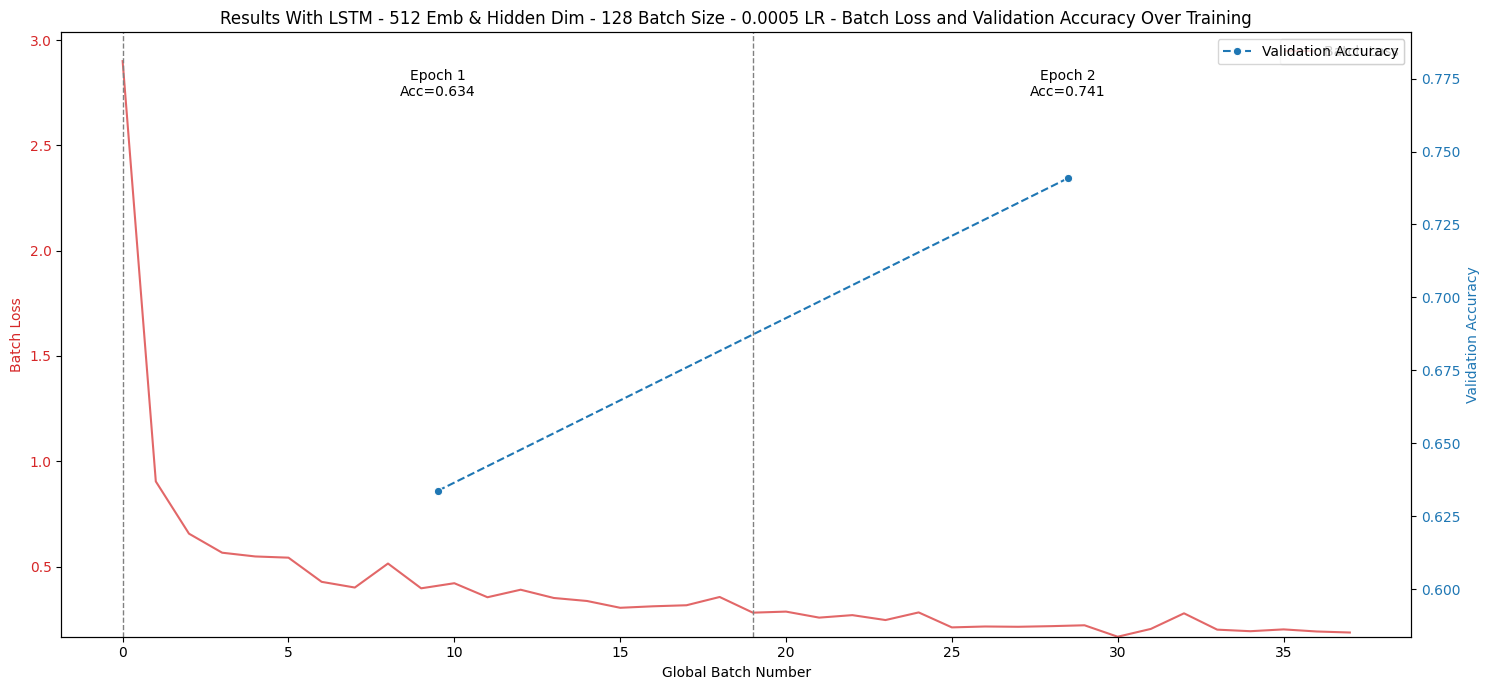

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
output_dir = "./results/results_comb_hyp_1"
os.makedirs(output_dir, exist_ok=True)

batches_loss['global_batch'] = range(len(batches_loss))

# Calculate the position for epoch markers
epoch_boundaries = batches_loss.groupby('epoch')['global_batch'].min().tolist()
epoch_boundaries.append(len(batches_loss)) 

# Get the center of each epoch
epoch_centers = [(epoch_boundaries[i] + epoch_boundaries[i+1]) / 2 for i in range(len(epoch_boundaries)-1)]


# Create the plot
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot batch loss on the primary y-axis
color = 'tab:red'
ax1.set_xlabel('Global Batch Number')
ax1.set_ylabel('Batch Loss', color=color)
sns.lineplot(data=batches_loss, x='global_batch', y='loss', ax=ax1, color=color, alpha=0.7, label='Batch Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(bottom=min(batches_loss["loss"]))

# Create a secondary y-axis for accuracy
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy', color=color)
sns.lineplot(data=epoch_val_acc, x=epoch_centers, y='accuracy', ax=ax2, color=color, marker='o', linestyle='--', label='Validation Accuracy')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(min(epoch_val_acc["accuracy"])-0.05, max(epoch_val_acc["accuracy"])+0.05)

# Add vertical lines and text for epoch boundaries
for i, boundary in enumerate(epoch_boundaries[:-1]):
    ax1.axvline(x=boundary, color='gray', linestyle='--', linewidth=1)
    # Add text label for the epoch
    ax1.text(epoch_centers[i], ax1.get_ylim()[1] * 0.90, f'Epoch {i+1}\nAcc={epoch_val_acc.iloc[i]["accuracy"]:.3f}', horizontalalignment='center', color='black')

plt.title('Results With LSTM - 512 Emb & Hidden Dim - 128 Batch Size - 0.0005 LR - Batch Loss and Validation Accuracy Over Training')
fig.tight_layout()
plt.savefig(f"{output_dir}/loss_and_acc_model.png")
plt.show()

In [20]:
batches_loss.to_csv(f"{output_dir}/batches_loss.csv")
epoch_val_acc.to_csv(f"{output_dir}/epoch_val_acc.csv")